# Import Dependencies

In [124]:
import os
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.metrics import classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_sample_weight

# Understanding the Dataset

In [3]:
path = os.path.join('datasets', 'creditcard', 'creditcard.csv')
pf = pd.read_csv(path)

In [4]:
# First five rows of the dataset
pf.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### This dataset includes 
- **30 features**
- one label column which is the **class of the transaction**, **0** for **not_fraud** and **1** for **fraud**
- No **null value**


In [5]:
pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Class imbalance

As expected, the credit card dataset is imbalanced, which means there are too many non-fraudulent (normal) transactions compared to fraudulent ones. 
In our case, there are: 
- **284315** normal transactions against only 
- **492** fraudulent transactions. 

As we'll see, this skewed data can affect the accuracy of the models. 

In [6]:
pf["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

### Feature scaling

Features have different scale! 

With the data description and histograms, we can see that 
- **V's features** are spread around **0** while
- **Time** and **Amount** ranges respectively from  **0** to **172792** and  **0** to **25691**.

This can affect the efficiency of the gradient descent algorithm. Indeed, it may take too long to converge.

To avoid this problem, we need to perform a data transformation called **feature scaling** on our features Time and Amount.
I'll apply the MinMax Normalization: 
$$x_i = \dfrac{x_i - min}{max - min} $$

In [7]:
# Quick statistical insights
pf.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

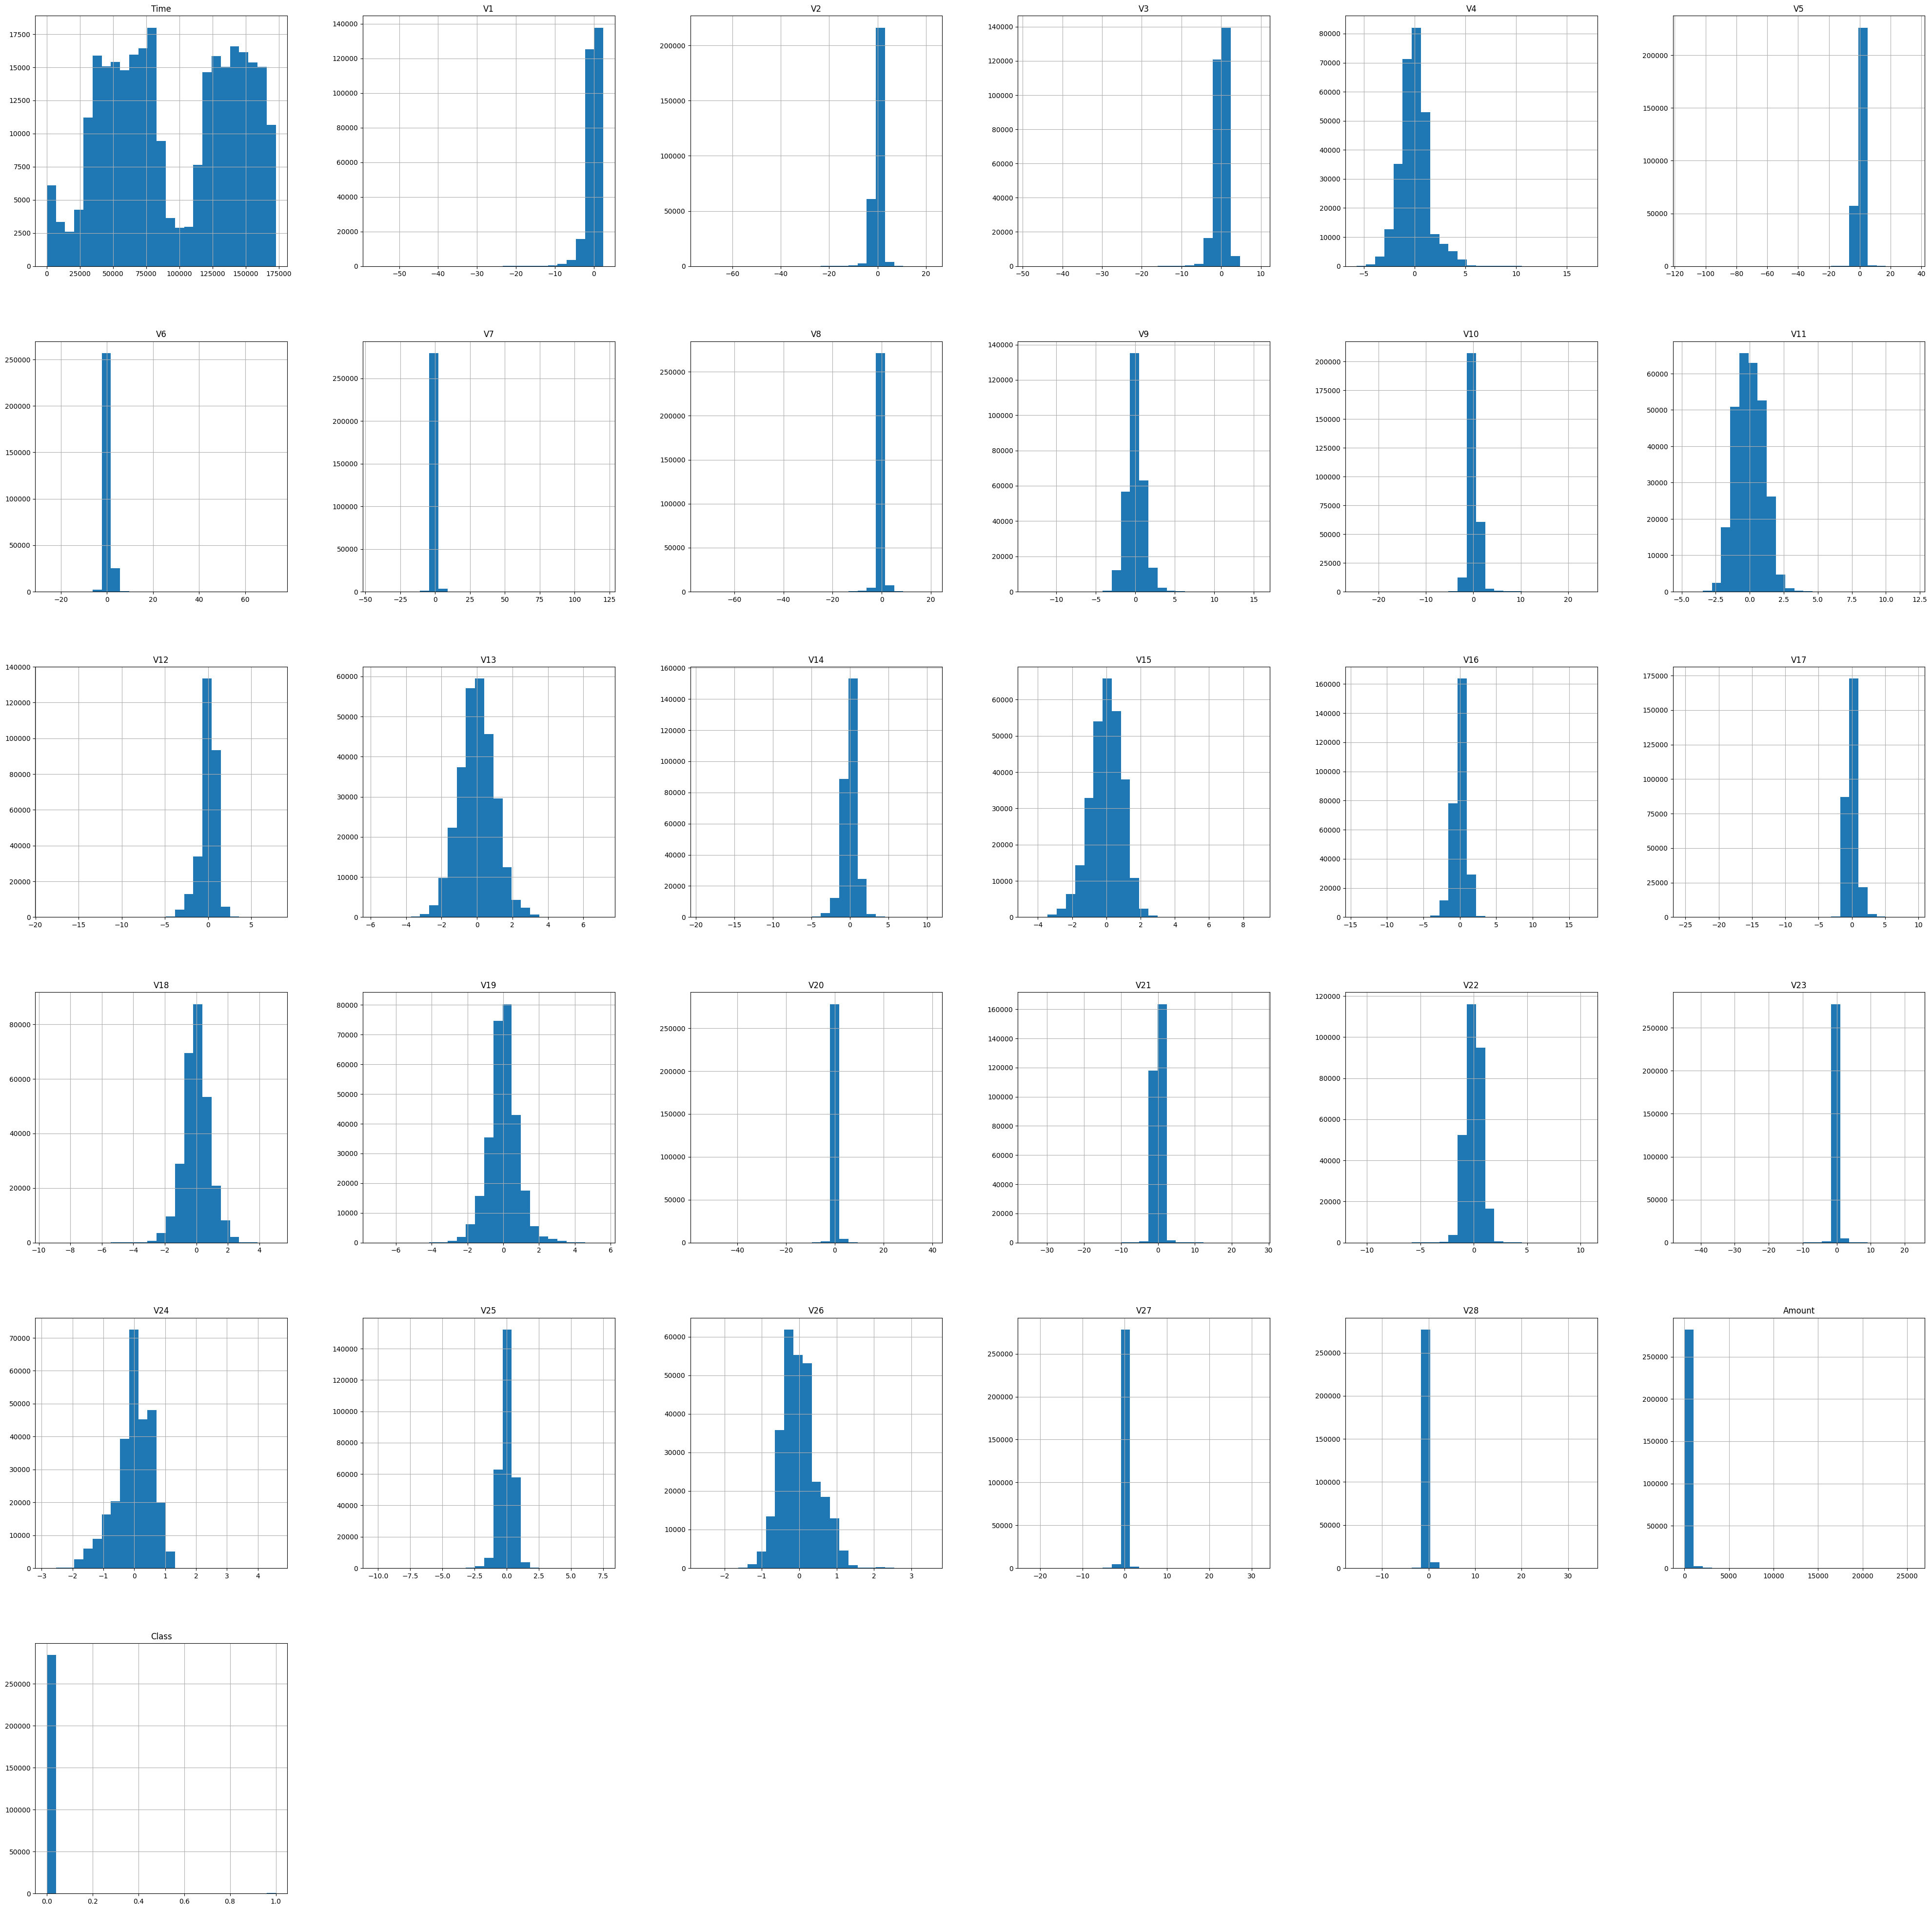

In [142]:
pf.hist(bins=25, figsize=(50,50))

<Axes: >

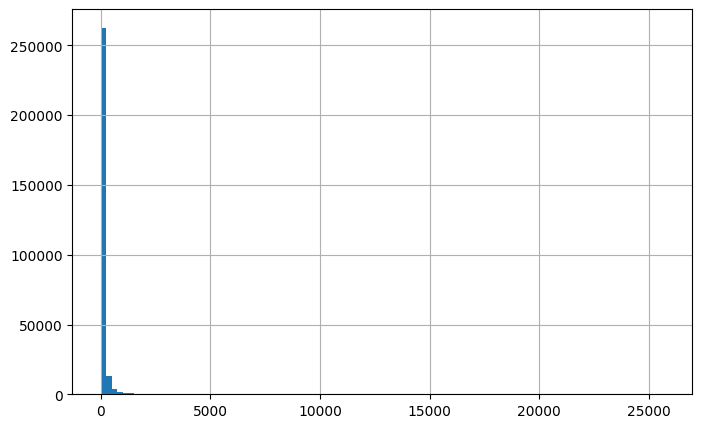

In [110]:
#Zoom in on the amount feature
pf["Amount"].hist(bins=100, figsize=(8, 5))

<Axes: >

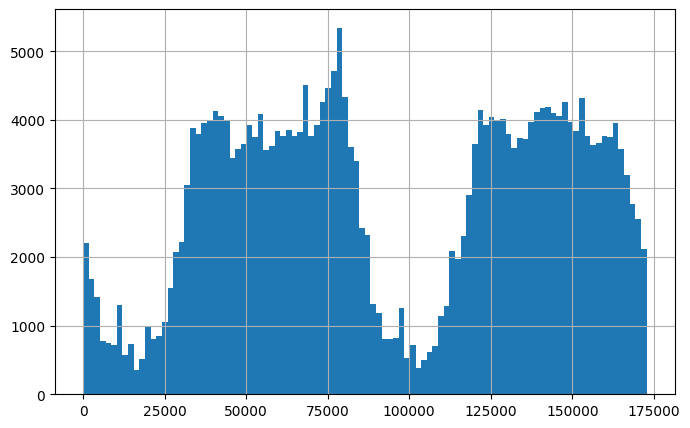

In [111]:
# Zoom in on the Time feature
pf["Time"].hist(bins=100, figsize=(8,5))

# Feature Engineering

In [11]:
# MinMax normalization 
new_pf = pf.copy()
new_pf["Time"] = MinMaxScaler().fit_transform(new_pf["Time"].to_numpy().reshape(-1,1))
new_pf["Amount"] = MinMaxScaler().fit_transform(new_pf["Amount"].to_numpy().reshape(-1,1))

In [12]:
new_pf.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,0.548717,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,0.003439,0.001727
std,0.274828,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.009736,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,0.313681,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000218,0.000000
50%,0.490138,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000856,0.000000
75%,0.806290,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.003004,0.000000
max,1.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000,1.000000


In [40]:
# How would you rescale the entire dataset at once?

# pf_just_for_review = pf.copy()
# # The fit_transform method learns the parameters from the training data (fit) and then 
# # applies the transformation using those learned parameters (transform) in one step.
# new_pf_just_for_review = MinMaxScaler().fit_transform(pf_just_for_review.to_numpy())

# # Convert numpy array back to DataFrame
# new_pf_just_for_review = pd.DataFrame(new_pf_just_for_review, columns=pf_just_for_review.columns)
# new_pf_just_for_review.describe()

#### Separate the features from the ground truth

In [13]:
Y = new_pf["Class"]
X = new_pf.drop("Class", axis=1)

In [14]:
X.shape

(284807, 30)

#### Split the dataset into train, validation and test set

In [15]:
x_train,x_,y_train,y_ = train_test_split(X, Y, test_size= 0.4, random_state=42)
x_test,x_val,y_test,y_val = train_test_split(x_, y_, test_size= 0.5, random_state=42)

# Delete temporary variables x_ and y_
del x_,y_ 

# Model building

In this section, we'll build our candidate models. 

As we saw in the last sections, our dataset is heavily imbalanced and we'll see its impact on model accuracy.

To mitigate this problem, we'll build three versions of each candidate model: 

- **imbalanced**: models with this label are trained on the entire training set,
  
- **balanced**: these models are trained on a re-balanced dataset by downsampling the majority class,
  
- **weighted**: trained on the entire training set with a weighted loss function. Weights are inversely proportional to the size of each class so that minority classes get higher weight. 

## Helper Functions

In [154]:
def displayLearningCurves(model, X, Y, train_sizes, perf_metric,name, version):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(f"Learning Curves of the {version}_{model.__class__.__name__} classifier")
    common_params = {
        "X": X,
        "y": Y,
        "train_sizes": train_sizes,
        "score_type": 'both',
        "cv": 5,  # As we're working with a classification problem cv used StratifiedKFold strategy
        "scoring": perf_metric,
        "n_jobs": 4,
        "line_kw": {"linestyle": "-", "marker": "o"},
        # "std_display_style": "fill_between",
        "score_name": name,
        "ax": ax
    }
    LearningCurveDisplay.from_estimator(estimator=model, **common_params)

In [103]:
# from sklearn.metrics import recall_score



# # Create classifier with more estimators to see the progression
# gb_clf = GradientBoostingClassifier(
#     n_estimators=200,
#     learning_rate=0.1,
#     max_depth=2,
#     random_state=42
# )

# # Fit the model
# gb_clf.fit(x_train, y_train)

# # Get training and validation scores for each boosting iteration
# train_scores = []
# val_scores = []

# for i, pred in enumerate(gb_clf.staged_predict(x_train)):
#     train_scores.append(recall_score(y_train, pred))

# for i, pred in enumerate(gb_clf.staged_predict(x_val)):
#     val_scores.append(recall_score(y_val, pred))

# # Plot the training progression
# plt.figure(figsize=(12, 8))

# # Plot 1: Accuracy vs Iterations
# plt.subplot(2, 1, 1)
# iterations = range(1, len(train_scores) + 1)
# plt.plot(iterations, train_scores, label='Training Accuracy', color='blue')
# plt.plot(iterations, val_scores, label='Validation Accuracy', color='red')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Accuracy')
# plt.title('Training Progress - Accuracy vs Boosting Iterations')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Plot 2: Training Loss (if available)
# plt.subplot(2, 1, 2)
# plt.plot(range(1, len(gb_clf.train_score_) + 1), gb_clf.train_score_, 
#          label='Training Loss', color='green')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Loss')
# plt.title('Training Loss vs Boosting Iterations')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Print some insights
# print(f"Best training accuracy: {max(train_scores):.4f} at iteration {np.argmax(train_scores) + 1}")
# print(f"Best validation accuracy: {max(val_scores):.4f} at iteration {np.argmax(val_scores) + 1}")
# print(f"Final training accuracy: {train_scores[-1]:.4f}")
# print(f"Final validation accuracy: {val_scores[-1]:.4f}")

# # Check for overfitting
# if max(train_scores) - max(val_scores) > 0.05:
#     print("Warning: Potential overfitting detected (large gap between train and validation)")
# else:
#     print("Model appears to be well-regularized")

In [2]:
# x = np.arange(0.,1.1,0.1)
# y_1 = -np.log(x)
# y_2 = -np.log(1-x)

In [1]:
# fig,ax = plt.subplots(1,2, figsize=(12,5), sharex=True)
# ax[0].plot(x,y_1, c='blue')
# ax[0].set_xlabel('Probability p')
# ax[0].set_ylabel('Entropy when y_i = 1')
# ax[1].plot(x,y_2, c='blue')
# ax[1].set_ylabel('Entropy when y_i = 0')
# ax[1].set_xlabel('Probability p')
# plt.show()

## Working with Imbalanced Versions

#### Logistic Regression

We're dealing with a classification problem! Given a transaction, our model should predict wheither it's fraudulent (1) or non-fraudulent(0) transaction. 

The logistic regression is one of the core ML classification algorithms. 
the logistic regression name might be a bit confusing, the regression part comes from the fact that the mathematical formulation of the logistic regression is very similar to that of the linear regression.

- In linear regression, the predictive function or model ${y_i}$ is defined as linear combination of the input data ${x_i}$ : ${y_i} = {w^{T}}{x_i} + {b}$ where (w,b) are the model parameters.


- In Logistic regression, the output takes discrete values, in this case 0 or 1 (binary classification) and therefore the predictive function defined earlier for linear regression would not work. We apply the logistic function to the linear combination of the input data. You can think of this function as the probability of a transaction being fraudulent. Obviously, it ranges from 0 to 1: depending on a threshold, transactions with probability value higher than the threshold would be classified as fraudulent and those with less than the threshold are the normal ones. The predictive function for logistic regression is defined as follow:


$${f_{w,b}({x_i})} = \frac{1}{1+\exp^{-({w^{T}}{x_i} + {b})}}$$


Once we get to this point, we need to define our **cost function** ${J({w,b})}$ which measures how well our model fits the data. The whole process of training an ML models is about tweaking the parameter to minimize this cost function. They are multiple ways to define a cost function. For logistic regression, the cost function is defined as the likelihood of the parameters, a probabilistic approach function that tells us how likely a set of paramters (and therefore the model) has generated the data. By maximizing this function, we get the best parameters that allows the model to fit well to the data. This estimation method of the parameter is called **Maximum likelihood estimation (MLE)**.

Since most of the optimization algorithms are designed to minimize cost functions, the likelihood is transformed into the negative log likelihood as follow:

$$ J({w,b}) = - \frac{1}{m}\sum\limits_{i = 1}^{m}(y_{i})\log\left(f_{\mathbf{w},b}\left( \mathbf{x}_{i} \right) \right) + \left( 1 - y_{i}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}_{i} \right) \right)$$



During the training process, the optimization algorithm, **Gradient descent**, is then applied to find parameters $\mathbf(w,b)$ that minimize this function.


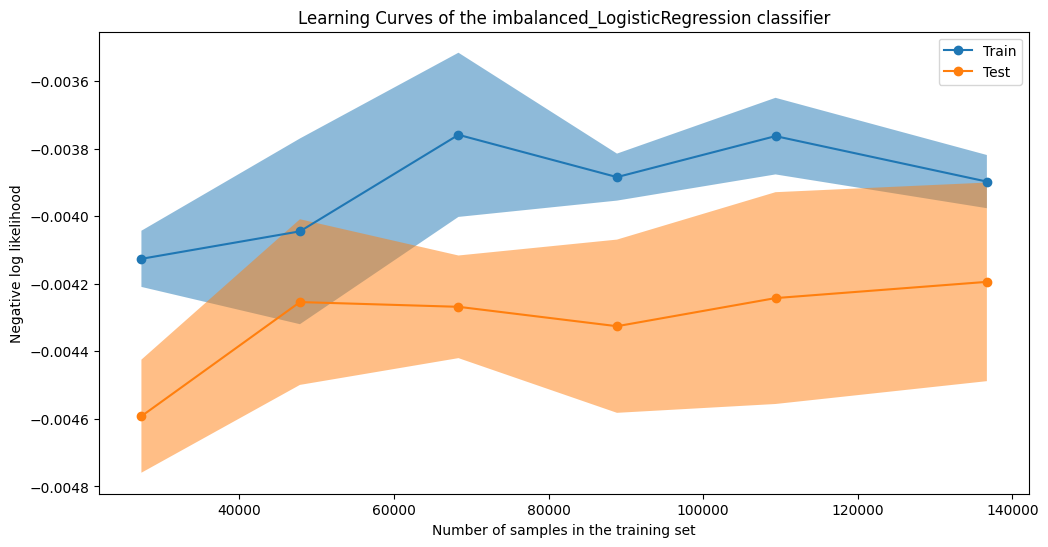

In [156]:
logistic_model_1 = LogisticRegression(max_iter=200)
displayLearningCurves(
    logistic_model_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative log likelihood',
    'imbalanced'
)

In [157]:
logistic_model_1.fit(x_train, y_train)
print(classification_report(y_val, logistic_model_1.predict(x_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56853
       Fraud       0.88      0.62      0.73       109

    accuracy                           1.00     56962
   macro avg       0.94      0.81      0.87     56962
weighted avg       1.00      1.00      1.00     56962



#### Decision trees


Decision tree algorithm is one of the most versatile algorithms which can be used in classification as well as in regression problems. In this section, we are going to use them as classifier to predict whether a transaction is fraudulent or not. 

You can think of decision tree as acyclic graph in which you have nodes and routes making the connection between nodes. At each node, the algorithm needs to take action (take one route or the other) based on certain condition (usually the condition is based on values of the feature at that node). The goal of the algorithm is to help us find the best features that recursively split the dataset into homogeneous subsets that lead ultimately to the target class (last nodes called leaf nodes).

The training process of a decision tree model is based on the homogeneity of subsets. To define it, we use something called **entropy** which is inversely proportional to the homogeneity of a subset, the more homogeneous a subset is the lower the entropy. At each node, we'll have two substets ${S_1}$ and ${S_2}$ with ${n_1}$ and ${n_2}$ their corresponding numbers of transactions. The weighted-average entropy of the two substets captures the the ability of a feature to create sparse data (less homogeneous subset).

- For a given subset with $p_1$ the proportion of fraudulent transactions, the entropy is given by: 

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1 - p_1) \text{log}_2(1- p_1)$$

- the weighted-average entropy (WAE) is then:
$$\text{WAE} = \dfrac{n_1}{{n_1}+{n_2}}{H^{S_1}}(p_1) + \dfrac{n_2}{{n_1}+{n_2}}{H^{S_2}}(p_1)$$

Again for convenience, we prefer the **information gain** which measures the reduction of the entropy after the split. if $H(S)$ denotes the entropy of a node, then the information gain is defined as follow:

$$\text{Information Gain} = H(S)- \text{WAE}$$

The splitting process continues until a stopping criteria is met which is the maximum depth(number of branches to go from the root node to the leaf nodes, max_depth = 2)


However, one of the main drawbacks of decision tree is that it's too sensitive to even small changes in the dataset. 
- **Random forest** is a set of decision trees built upon different samples drawn from the original dataset by sampling with replacement. Moreover, at each node, when choosing a feature to use to split, if n features are available, it picks a random subset of ${k<n}$ features and allow the algorithm to only choose from that subset of features. A typical choice for k when n is too large is ${\sqrt{n}}$.

- **XGBoost** is a variant of random forest, instead of picking from all examples with equal probability p, we make it more likely to pick data point that the **previous tree is misclassifiying**.

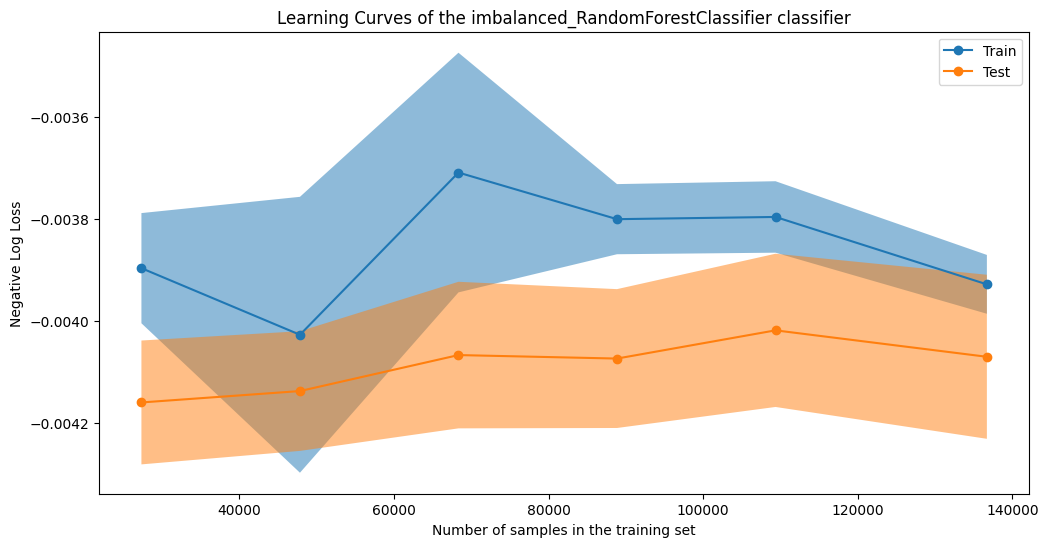

In [160]:
rf_1 = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)
displayLearningCurves(
    rf_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'imbalanced'
)

In [161]:
rf_1.fit(x_train,y_train)
print(classification_report(y_val, rf_1.predict(x_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56853
       Fraud       0.85      0.58      0.69       109

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962



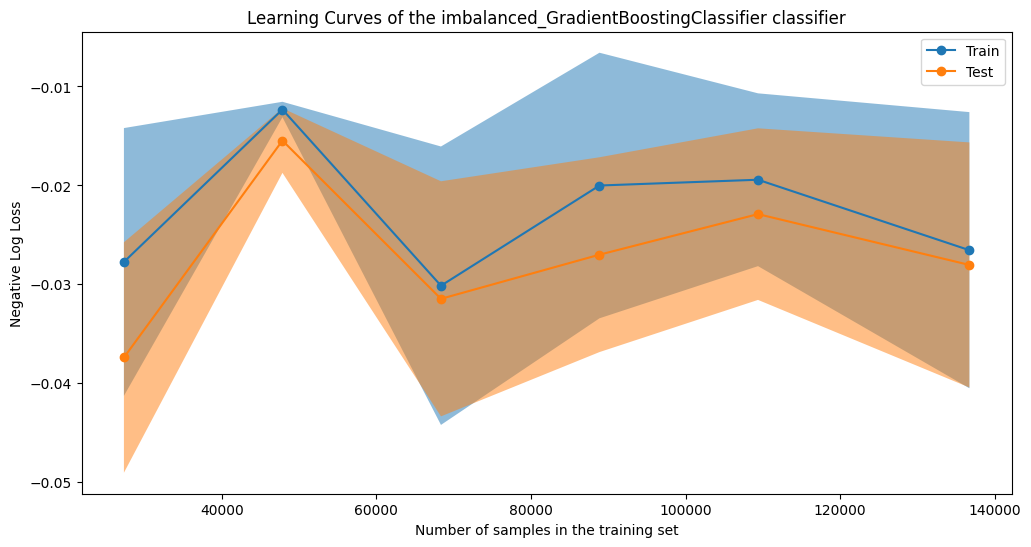

In [165]:
xgb_1 = GradientBoostingClassifier(
    n_estimators=50, # controls the number of trees in the forest. It’s a fixed number.
    max_depth=2, 
    learning_rate= 0.1, 
    random_state=42
)

displayLearningCurves(
    xgb_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'imbalanced'
)


In [163]:
xgb_1.fit(x_train,y_train)
print(classification_report(y_val, xgb.predict(x_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56853
       Fraud       0.82      0.66      0.73       109

    accuracy                           1.00     56962
   macro avg       0.91      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



#### Support Vector Machine

In [15]:
svc_1 = LinearSVC()
displayLearningCurves(
    svc_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'imbalanced'
)


              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56853
       Fraud       0.87      0.60      0.71       109

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
svc.fit(x_train, y_train)
print(classification_report(y_val, svc.predict(x_val), target_names = ['Non Fraud','Fraud']))

## Working with Balanced Versions

#### Re-balancing the dataset

In [134]:
new_pf_copy = new_pf.copy()
non_fraud_pf = new_pf_copy[new_pf_copy["Class"] == 0].reset_index(drop=True) # indexes get dropped and restart from 0
fraud_pf = new_pf_copy[new_pf_copy["Class"] == 1].reset_index(drop=True)
non_fraud_pf.info()
#fraud_pf.info()

#Downsample the non_fraud datatframe
non_fraud_pf = resample(
    non_fraud_pf,
    replace= True, 
    n_samples= len(fraud_pf), 
    random_state= 42
).reset_index(drop=True)
print("\n\n\n")
non_fraud_pf.info()

balanced_pf = pd.concat([non_fraud_pf, fraud_pf], axis= 0, ignore_index= True)\
                .sample(frac=1, random_state=42)\
                .reset_index(drop=True)

print("\n\n\n The dataset is now balanced\n")
balanced_pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284315 entries, 0 to 284314
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284315 non-null  float64
 1   V1      284315 non-null  float64
 2   V2      284315 non-null  float64
 3   V3      284315 non-null  float64
 4   V4      284315 non-null  float64
 5   V5      284315 non-null  float64
 6   V6      284315 non-null  float64
 7   V7      284315 non-null  float64
 8   V8      284315 non-null  float64
 9   V9      284315 non-null  float64
 10  V10     284315 non-null  float64
 11  V11     284315 non-null  float64
 12  V12     284315 non-null  float64
 13  V13     284315 non-null  float64
 14  V14     284315 non-null  float64
 15  V15     284315 non-null  float64
 16  V16     284315 non-null  float64
 17  V17     284315 non-null  float64
 18  V18     284315 non-null  float64
 19  V19     284315 non-null  float64
 20  V20     284315 non-null  float64
 21  V21     28

#### train, val, test sets

In [136]:
Yb = balanced_pf["Class"]
Xb = balanced_pf.drop("Class", axis=1)

#Splitting into training, eval and test sets
xb_train,xb_,yb_train,yb_ = train_test_split(Xb, Yb, test_size= 0.4, random_state=42)
xb_test,xb_val,yb_test,yb_val = train_test_split(xb_, yb_, test_size= 0.5, random_state=42)

# Delete temporary variables x_ and y_
del xb_,yb_ 

#### Logistic Regression

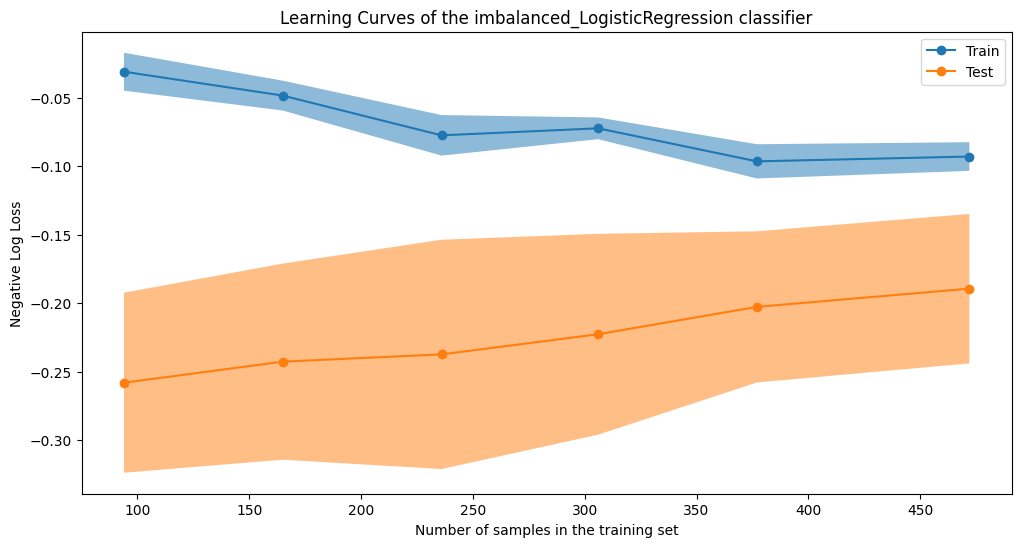

In [166]:
logistic_model_2 = LogisticRegression(max_iter=200, random_state=42)
displayLearningCurves(
    logistic_model_2 , 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'imbalanced'
)


In [167]:
logistic_model.fit(xb_train, yb_train)
print(classification_report(yb_val, logistic_model.predict(xb_val), target_names=['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       0.98      0.51      0.67       113
       Fraud       0.60      0.99      0.75        84

    accuracy                           0.72       197
   macro avg       0.79      0.75      0.71       197
weighted avg       0.82      0.72      0.71       197



#### Decision trees

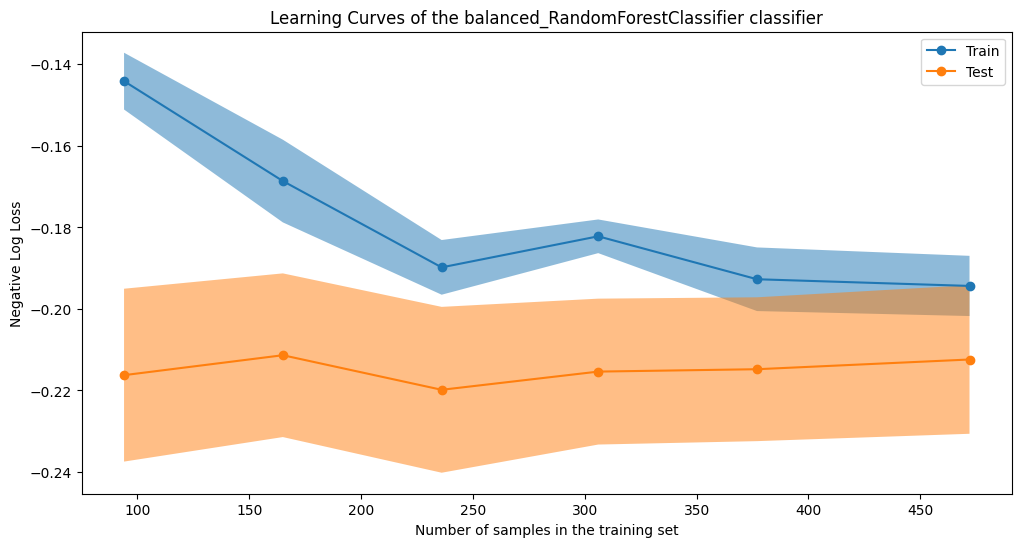

In [168]:
rf_2 = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)
displayLearningCurves(
    rf_2, 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'balanced'
)


In [169]:
rf_2.fit(xb_train,yb_train)
print(classification_report(yb_val, rf_2.predict(xb_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       0.88      1.00      0.94       113
       Fraud       1.00      0.82      0.90        84

    accuracy                           0.92       197
   macro avg       0.94      0.91      0.92       197
weighted avg       0.93      0.92      0.92       197



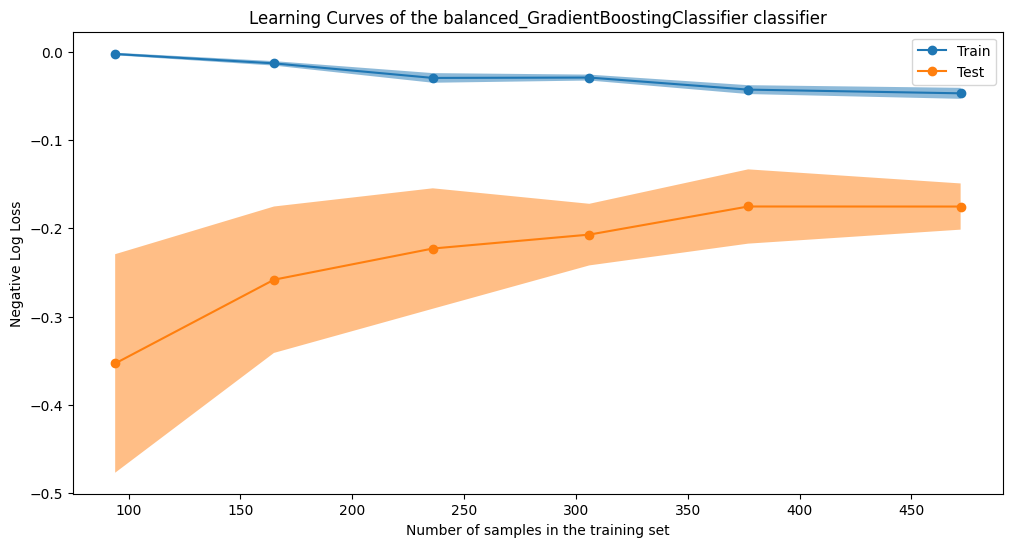

In [173]:
xgb_2 = GradientBoostingClassifier(n_estimators=75, max_depth=2, learning_rate= 0.1, random_state=42)
displayLearningCurves(
    xgb_2, 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'balanced'
)

In [174]:
xgb_2.fit(xb_train,yb_train)
print(classification_report(yb_val, xgb_2.predict(xb_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       0.93      0.95      0.94       113
       Fraud       0.93      0.90      0.92        84

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



#### Support Vector Machine

In [140]:
svc = LinearSVC()
svc.fit(xb_train,yb_train)

print(classification_report(yb_val, svc.predict(xb_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       0.92      0.96      0.94       113
       Fraud       0.94      0.89      0.91        84

    accuracy                           0.93       197
   macro avg       0.93      0.92      0.93       197
weighted avg       0.93      0.93      0.93       197



## Working with Weighted Versions

#### Logistic Regression

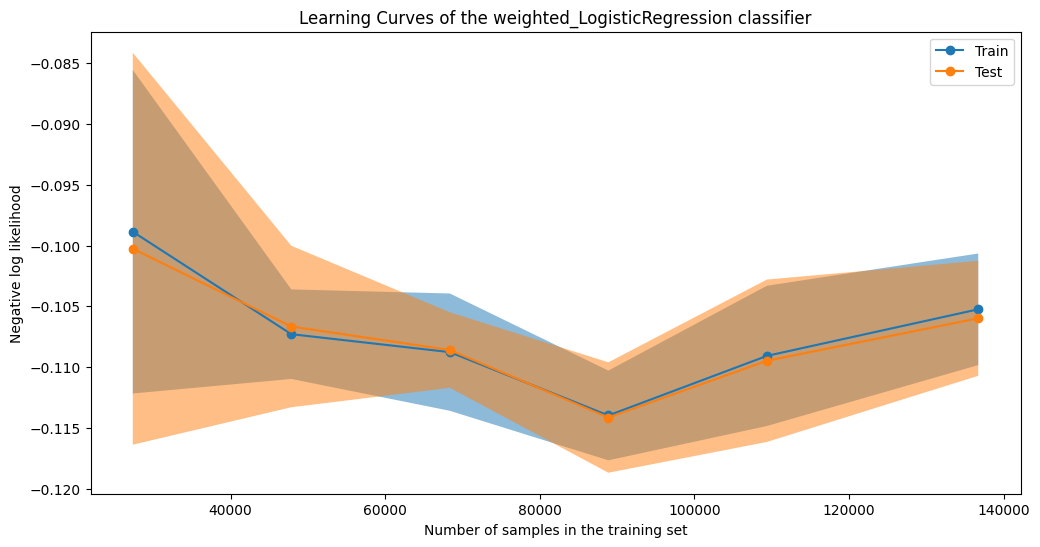

In [175]:
logistic_model_3 = LogisticRegression(max_iter=200, class_weight='balanced', random_state=42)
displayLearningCurves(
    logistic_model_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative log likelihood',
    'weighted'
)

In [176]:
# print(hasattr(logistic_model_2, 'coef_'))
logistic_model_3.fit(x_train, y_train)
print(classification_report(y_val, logistic_model_3.predict(x_val), target_names=['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.98      0.99     56853
       Fraud       0.07      0.93      0.13       109

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962



#### Decision trees

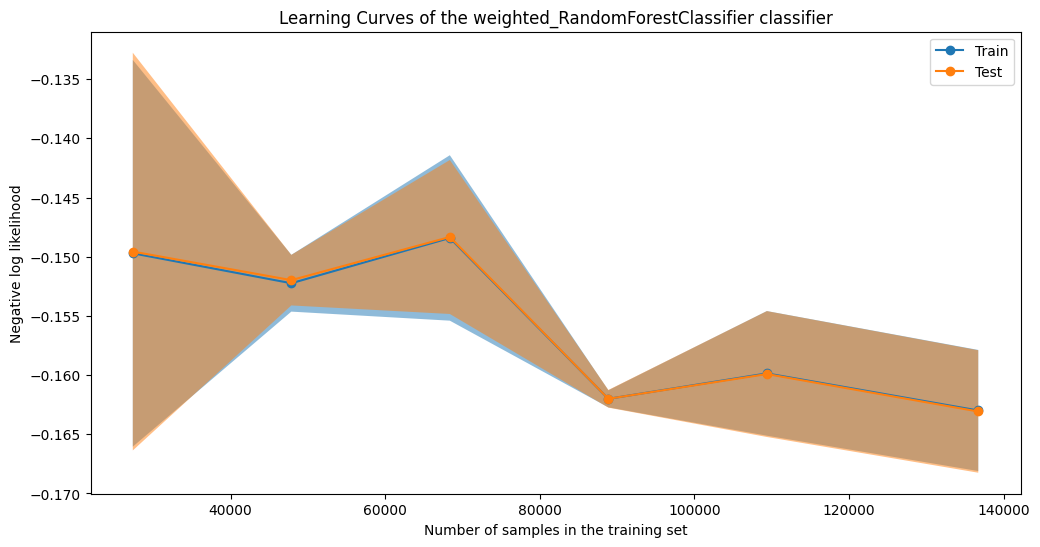

In [177]:
rf_3 = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42, class_weight='balanced')
displayLearningCurves(
    rf_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative log likelihood',
    'weighted'
)

In [178]:
rf_3.fit(x_train,y_train)
print(classification_report(y_val, rf_3.predict(x_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56853
       Fraud       0.47      0.86      0.61       109

    accuracy                           1.00     56962
   macro avg       0.74      0.93      0.80     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
xgb_3 = GradientBoostingClassifier(n_estimators=75, max_depth=2, learning_rate= 0.1, random_state=42)
sample_weight = compute_sample_weight('balanced', y_train)

displayLearningCurves(
    xgb_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative log likelihood',
    'weighted'
)


In [ ]:
xgb.fit(x_train,y_train, sample_weight=sample_weight)
print(classification_report(y_val, xgb.predict(x_val), target_names = ['Non Fraud','Fraud']))

#### Support Vector Machine

In [14]:
svc = LinearSVC(class_weight='balanced')
svc.fit(x_train,y_train)

print(classification_report(y_val, svc.predict(x_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.98      0.99     56853
       Fraud       0.09      0.93      0.16       109

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962



# Conclusion